In [2]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm
from scipy.optimize import curve_fit
import seaborn as sns

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection
from lib.analysis.correlation import FunctionalConnectivityMatrix

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [3]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# combine the dataframes
ppr_df = ppr_coronal_df.append(ppr_sagittal_df)
output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,2,5.388340,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1214,1,5.504880,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home
1215,2,7.391860,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1216,1,7.935810,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home


In [4]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df


,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,1,3,1,1/2/2025
1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02,1,3,2,1/2/2025
2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,1.0,Coronal,01_03_03,1,3,3,1/2/2025
3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,1,3,4,1/2/2025
4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,336,20,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,1,3,5,1/2/2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,116,70,NaN,NaN,116,100,120,1,NaN,Sagittal,03_02_22,3,2,22,4/16/2025
670,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,3,2,23,4/16/2025
671,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,NaN,NaN,176,100,90,1,NaN,Sagittal,03_02_24,3,2,24,4/16/2025
672,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25,3,2,25,4/16/2025


In [5]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,...,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,2,5.388340,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25
2369,1,5.504880,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26
2370,2,7.391860,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26
2371,1,7.935810,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26


In [6]:
# set matplotlib font to size 22
plt.rcParams.update({'font.size': 48})

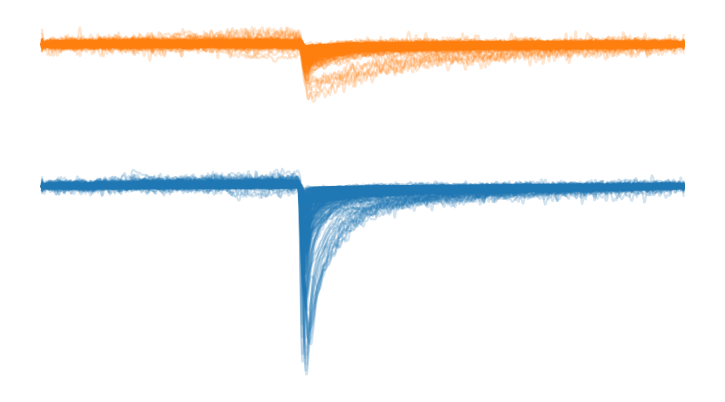

In [7]:
plt.figure(figsize=(10, 6))
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"
            for ipi in loc_df['IPI'].unique():
                ipi_df = loc_df[loc_df['IPI'] == ipi]
                #print(f" {date} {slic_loc_id} IPI {ipi}ms")
                
                # for each ROI, there should be two rows in ipi_df, one for control 
                # (is_single_pulse_control = 1) and one for experimental
                # (is_single_pulse_control = 0)
                # the trace files are the same for each ROI, so we can just load them once
                control_df = ipi_df[ipi_df['is_single_pulse_control'] == 1]
                ppr_sub_df = ipi_df[ipi_df['is_single_pulse_control'] == 0]
                
                # load trace and trace_non_polyfit files
                control_trace = read_dat_trace_file(control_df['trace'].values[0])
                control_trace_non_polyfit = read_dat_trace_file(control_df['trace_non_polyfit'].values[0])
                ppr_trace = read_dat_trace_file(ppr_sub_df['trace'].values[0])
                ppr_trace_non_polyfit = read_dat_trace_file(ppr_sub_df['trace_non_polyfit'].values[0])

                # subtract non-polyfit control from ppr
                sub_non_polyfit = ppr_trace_non_polyfit - control_trace_non_polyfit

                # calculate the dist from zero of subtracted trace around the second stim
                trace_sub_dist = sub_non_polyfit[(sub_non_polyfit.index < 356) | (sub_non_polyfit.index > 550)].abs().mean()
                # normalize this to the max of the trace within the the second stim measure window
                trace_sub_dist = trace_sub_dist / sub_non_polyfit[(sub_non_polyfit.index > 356) | (sub_non_polyfit.index < 550)].max()

                # calculate maxAmp of subtracted trace in measure window of second stim (356-450)
                trace_sub_max = sub_non_polyfit[(sub_non_polyfit.index > 356) & (sub_non_polyfit.index < 450)].max()

                # perform baseline correction on control trace 
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace_non_polyfit, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace_non_polyfit[(control_trace_non_polyfit.index > first_stim_start) 
                                                        & (control_trace_non_polyfit.index < first_stim_start + 104)]['Corrected_'+roi].max()

                # extract first and second maxAmp of ppr_trace. This is the non-subtracted PPR.
                first_maxAmp_non_sub = ppr_trace[(ppr_trace.index > first_stim_start) & 
                                                      (ppr_trace.index < 345)].max()
                second_maxAmp_non_sub = ppr_trace[(ppr_trace.index > 356) & (ppr_trace.index < 550)].max()

                # filter based on trace_sub_dist
                skip_plot = False
                if trace_sub_dist.mean() > 0.18:
                    skip_plot = True

                # plot all traces
                n_rois = len(control_trace.columns) - 1

                for i_roi, roi in enumerate(control_trace.columns):
                    
                    if roi == 'Pt':
                        continue
                    if not skip_plot:
                        t = control_trace.index * 0.5
                        if np.max(sub_non_polyfit[roi][:356]) > 2.5 or np.min(sub_non_polyfit[roi]) < -2.5:
                            continue
                        plt.plot(t, -sub_non_polyfit[roi] - (20 if roi == 'ROI1' else 0), 
                                label='Subtracted', 
                                color='tab:blue' if roi == 'ROI1' else 'tab:orange',
                                alpha=0.2)

#plt.legend(handles=[l1[0], l2[0]], labels=['Home Barrel', 'Neighbor Barrel'], loc='upper right')
plt.tight_layout()

# turn off spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.savefig(output_fig_dir + 'home_neighbor_traces.png')
plt.show()

In [8]:
# restrict to is_single_pulse_control = 0 (to avoid duplicates)
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]

# and restrict to substring 'pulse1' in "ROI_Set" column (to avoid duplicates)
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# how many unique date, slice, location combinations are there?
n_unique = len(ppr_df.groupby(['Date', 'Slice', 'Location']).size())
n_unique

29

In [9]:
ppr_df.columns

Index(['ROI', 'amp', 'latency', 'halfwidth', 'X_Center', 'Y_Center', 'ROI_Set',
       'Date', 'Slice', 'Location', 'Recording', 'trace', 'trace_non_polyfit',
       'amp_array', 'Medial/Lateral', 'Section', 'Rostral/Caudal',
       'pulse1_start', 'pulse1_width', 'pulse2_start', 'pulse2_width',
       'baseline_start', 'baseline_width', 'IPI', 'is_single_pulse_control',
       'done', 'Coronal/Sagittal', 'zda_id'],
      dtype='object')

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_20316\2604919270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')


          Date  Slice  Location Barrel_Type       ROI        amp     latency  \
0    1/15/2025      1         3        Home  1.000000   1.686665  116.671800   
1    1/15/2025      1         3    Neighbor  2.000000   0.236909  117.258700   
2    1/15/2025      3         2        Home  1.000000  22.781598  108.501327   
3    1/15/2025      3         2    Neighbor  2.000000   2.731071  107.689550   
4     1/2/2025      1         3        Home  1.000000   0.265125  113.318755   
5     1/2/2025      1         3    Neighbor  2.000000   0.247060  109.204010   
6     1/2/2025      2         2        Home  1.000000  10.009029  105.193483   
7     1/2/2025      2         2    Neighbor  2.000000   2.550743  103.629355   
8    1/22/2025      1         2        Home  1.000000   5.391039  110.272888   
9    1/22/2025      1         2    Neighbor  2.000000   3.354327  108.650196   
10   1/22/2025      3         2        Home  1.000000   8.190175  103.859160   
11   1/22/2025      3         2    Neigh

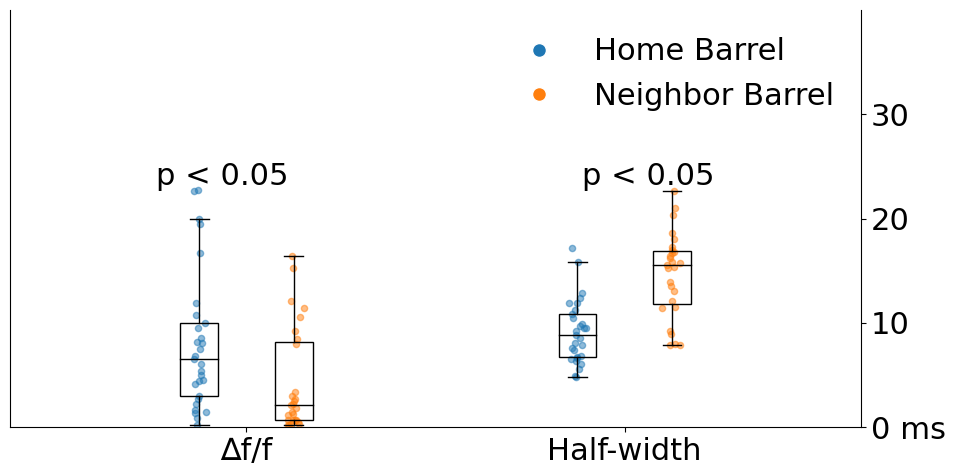

In [10]:
# compare amp, hw, latency for home barrel versus all other barrels
# Assuming `ppr_df` is your DataFrame and contains the necessary columns
# Filter for positive values

which_layer = 'L4'
filtered_df = ppr_df[(ppr_df['amp'] > 0) & (ppr_df['halfwidth'] > 0)]

# Add a column to distinguish between home barrel and other barrels
filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')
#filtered_df['amp'] /= 10 # convert to % change

plt.figure(figsize=(10, 6))

# average into a single value for each date, slice, location, and barrel type
filtered_df = filtered_df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
print(filtered_df)
print("Sample size home: ", len(filtered_df[filtered_df['Barrel_Type'] == 'Home']))
print("Sample size neighbor: ", len(filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']))

# create boxplot and overlay with scatterplot. Do not use sns.boxplot() because it does not allow for jittering
for j, metric in enumerate(['amp', 'halfwidth']):
    for i, barrel_type in enumerate(['Home', 'Neighbor']):
        # Filter the DataFrame for the current barrel type
        filtered_subset = filtered_df[filtered_df['Barrel_Type'] == barrel_type]
        # Create a boxplot for the current metric and barrel type
        plt.boxplot(filtered_subset[metric], positions=[i * 0.25 + j], widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor='none',
                color='black'), medianprops=dict(color='black'), showfliers=False)
        # Overlay with scatterplot (jittered)
        jittered_x = np.random.normal(j, 0.01, size=len(filtered_subset[metric]))
        plt.scatter(jittered_x + i * 0.25, filtered_subset[metric], 
                color=('tab:blue' if barrel_type == 'Home' else 'tab:orange'), alpha=0.5, s=20, label=barrel_type)
plt.xticks([0, 1], ['Home Barrel', 'Neighbor Barrel'], fontsize=22)
plt.yticks(fontsize=22)

# print the mean and std for each group
for barrel_type in ['Home', 'Neighbor']:
    mean_amp = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['amp'].mean()
    std_amp = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['amp'].std()
    mean_hw = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['halfwidth'].mean()
    std_hw = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['halfwidth'].std()
    print(f"{barrel_type} Barrel: Amp: {mean_amp:.2f} ± {std_amp:.2f}, Halfwidth: {mean_hw:.2f} ± {std_hw:.2f}")

# y label is ∆f/f (a. u.) at left and halfwidth (ms) at right
# no ticks at left y axis
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.gca().yaxis.tick_left()
plt.gca().yaxis.set_label_position('left')
#plt.gca().set_ylabel('∆f/f (a. u.)', fontsize=22, labelpad=20)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Adjust the y-coordinate of the label position


# Customize the plot
#plt.title('Comparison of Amp, HW, and Latency: Home Barrel vs Other Barrels')
# legend shows only the first two labels
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Home Barrel',
                markerfacecolor='tab:blue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Neighbor Barrel',
                markerfacecolor='tab:orange', markersize=10)],
                loc='upper right', fontsize=22, frameon=False)
#plt.legend()
plt.tight_layout()

# significance testing
amp_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['amp']
amp_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['amp']
amp_ttest = ttest_ind(amp_home, amp_neighbor, equal_var=False)
amp_ttest_p = amp_ttest.pvalue
if amp_ttest_p < 0.05:
    print(f"Significant difference in amp between home and neighbor barrels: p = {amp_ttest_p:.4f}")
    print("T-test results:")
    print(f"t-statistic: {amp_ttest.statistic:.4f}, p-value: {amp_ttest.pvalue:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.25, 0.6, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

hw_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['halfwidth']
hw_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['halfwidth']
hw_ttest = ttest_ind(hw_home, hw_neighbor, equal_var=False)
hw_ttest_p = hw_ttest.pvalue
if hw_ttest_p < 0.05:
    print(f"Significant difference in halfwidth between home and neighbor barrels: p = {hw_ttest_p}")
    print("T-test results:")
    print(f"t-statistic: {hw_ttest.statistic:.4f}, p-value: {hw_ttest.pvalue:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.75, 0.60, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

#plt.ylabel('Value (∆f/f or ms)')
plt.ylim(0, 40)
plt.xticks([0.125, 1.125])
# set x tick labels 
plt.gca().set_xticklabels(['∆f/f', 'Half-width' ], fontsize=22)
plt.xlabel('')

# set y-label on the right side for halfwidth
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
#plt.gca().set_ylabel('Half-width (ms)', fontsize=22, labelpad=20)

plt.gca().spines['top'].set_visible(False)

# set y label ticks to be 0, 5, 10, 15
plt.gca().set_yticks([0, 10, 20, 30])
plt.gca().set_yticklabels(['0 ms', 10, 20, 30], fontsize=22)

# Show the plot
plt.savefig(output_fig_dir + 'home_vs_neighbor_barrels.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# Restrict to neighbor barrels (ROI > 1)
ppr_df = ppr_df[ppr_df['ROI'] > 1]

# barplot of hw, lat, and amp for rostral, caudal, medial, and lateral barrels

barrel_df = ppr_df.copy()
barrel_df.loc[barrel_df['Section'] == 'Sagittal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Sagittal']['Rostral/Caudal']
barrel_df.loc[barrel_df['Section'] == 'Coronal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Coronal']['Medial/Lateral']
barrel_df['latency'] -= (barrel_df['pulse1_start'] / 2 - 1.4)  # adjust latency to account for the first stim time
barrel_df 

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Barrel_Type
1,2,0.330619,3.9850,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,Lateral
9,2,0.122340,6.1130,10.10660,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,Lateral
13,2,0.000000,169.4000,-361.92500,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,Lateral
21,2,0.362766,5.1331,30.18870,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,96,360,130,0,1.0,Coronal,01_03_08,Lateral
27,2,0.135539,6.2248,16.74330,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,136,320,110,0,1.0,Coronal,01_03_10,Lateral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2,9.340670,6.5430,9.34067,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,256,200,50,0,NaN,Sagittal,03_02_17,Rostral
2350,2,2.474920,7.7370,2.47492,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,296,160,30,0,NaN,Sagittal,03_02_19,Rostral
2356,2,8.431020,6.2895,8.43102,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,116,340,120,0,NaN,Sagittal,03_02_21,Rostral
2362,2,15.102300,3.6166,15.10230,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,Rostral


In [12]:
# read in final ladder velocities as well 'export_summary_final_velocity_ladders.csv'
ladder_df = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_final_velocity_ladders.csv'
ladder_df = pd.read_csv(ladder_df)

# only Layer == 'L4' 
ladder_df = ladder_df[ladder_df['Layer'] == 'L4']
print(ladder_df['Medial/Lateral'].unique())
ladder_df

[nan 'Lateral' 'Medial']


,ROI,amp,snr,latency,halfwidth,Stim_Distance,X_Center,Y_Center,ROI_Set,Date,...,trace,Dist_from_home_barrel,resides_in_barrel,instantaneous_velocity,ROI file,drug,Layer,Medial/Lateral,Age,Sex
202,1,1.14860,5.76071,4.1845,9.91258,309.741828,50.175676,8.337838,3_rois_output__ladder_,7/17/2024,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,388.536514,NaN,65.104863,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,ACSF,L4,NaN,62,F
203,2,1.46373,10.43580,3.9140,6.36216,293.264386,51.294872,11.051282,3_rois_output__ladder_,7/17/2024,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,370.925649,NaN,44.614970,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,ACSF,L4,NaN,62,F
204,3,1.58534,11.34920,3.5099,11.90630,274.758075,52.424658,13.835616,3_rois_output__ladder_,7/17/2024,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,352.896740,NaN,80.408649,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,ACSF,L4,NaN,62,F
205,4,1.99899,13.01990,3.7306,9.99551,255.264569,54.098592,16.352113,3_rois_output__ladder_,7/17/2024,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,335.150551,NaN,232.437797,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,ACSF,L4,NaN,62,F
206,5,2.66468,15.50890,3.8085,9.13839,239.774894,55.306667,19.120000,3_rois_output__ladder_,7/17/2024,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,317.043647,NaN,104.480100,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,ACSF,L4,NaN,62,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,22,10.51380,NaN,32.4017,10.51380,87.361319,68.000000,42.000000,3_rois_output__ladder_ pulse1,4/16/2025,...,NaN,66.068147,Home,113.564718,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,ACSF,L4,NaN,41,F
1425,23,10.49920,NaN,32.5608,10.49920,93.914855,71.000000,42.500000,3_rois_output__ladder_ pulse1,4/16/2025,...,NaN,48.000000,NaN,245.566166,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,ACSF,L4,NaN,41,F
1426,24,11.14110,NaN,32.6341,11.14110,103.227903,74.000000,42.500000,3_rois_output__ladder_ pulse1,4/16/2025,...,NaN,30.000000,NaN,185.375901,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,ACSF,L4,NaN,41,F
1427,25,10.71790,NaN,32.7312,10.71790,114.629839,77.000000,42.500000,3_rois_output__ladder_ pulse1,4/16/2025,...,NaN,12.000000,NaN,168.302945,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,ACSF,L4,NaN,41,F


In [13]:
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

nbqx_export_sagittal = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/' + "export_summary_backup.csv"
hw_lat_sagittal_df = pd.read_csv(nbqx_export_sagittal)
hw_lat_sagittal_df
hw_lat_df['Section'] = 'Coronal'
hw_lat_sagittal_df['Section'] = 'Sagittal'

# merge the two hw_lat dataframes
hw_lat_df = pd.concat([hw_lat_df, hw_lat_sagittal_df], ignore_index=True)

# only need drug == "ACSF"
hw_lat_df = hw_lat_df[hw_lat_df['drug'] == 'ACSF']

# only keep dates that are not already in barrel_df
hw_lat_df = hw_lat_df[~hw_lat_df['Date'].isin(barrel_df['Date'].unique())]

# only keep L4 in Layer column and ROI > 1
hw_lat_df = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & (hw_lat_df['ROI'] > 1)]
hw_lat_df

,Layer,drug,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,...,Slice,Location,Recording,Medial/Lateral,trace,Section,Stim_Distance,amp_array,snr_array,Rostral/Caudal
5,L4,ACSF,2,0.983708,39.2649,4.9494,12.78330,29.060606,33.034091,1_rois,...,1,1,1,Medial,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,Coronal,NaN,NaN,NaN,NaN
9,L4,ACSF,2,3.041910,23.2155,2.3892,15.21730,51.851974,29.101974,2_rois,...,2,1,1,Lateral,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,Coronal,NaN,NaN,NaN,NaN
21,L4,ACSF,2,12.553400,70.3597,2.0402,7.41857,52.287425,11.059880,1_rois,...,1,1,3,Lateral,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,Coronal,NaN,NaN,NaN,NaN
45,L4,ACSF,2,8.699790,42.8321,3.0089,6.29783,NaN,NaN,NaN,...,3,1,1,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,Coronal,NaN,NaN,NaN,NaN


In [14]:
# concat barrel_df and hw_lat_df and name it all_barrel_df
all_barrel_df = pd.concat([barrel_df, hw_lat_df], ignore_index=True)
all_barrel_df
# print all latencyes between 0 and 20
print("Latency values:", all_barrel_df[(all_barrel_df['latency'] > 0) & (all_barrel_df['latency'] <20)
                                       ]['latency'].unique())

Latency values: [ 3.985   6.113   5.1331  6.2248  7.642   7.227   6.9021  5.118   4.8864
  4.5178  5.193   6.4933  6.643   7.0896  7.986   7.186   7.592   7.546
  6.8707  7.251   6.307   6.577   6.7426  6.8667  5.1721  5.776   5.7077
  5.5289  5.783   5.4831  5.82    5.7715  6.378   5.824   5.893   5.678
  5.901   6.314   5.3848  6.023   5.8539  5.483   5.631   5.544   5.3634
  5.296   5.731   5.2345  5.681   5.3387  8.2793  8.8002  5.847   6.687
  5.81    6.415   5.3619  6.3265  5.8364  7.0966  6.271   7.643   5.7388
  7.4062  6.27    6.977   6.0832  6.8661  5.758   6.426   5.652   6.155
  6.471   6.065   6.455   6.6841  6.833   6.701   6.3425  7.027   6.6645
  6.739   6.2914  7.29    7.4478  7.373   7.265   9.176   5.207   4.755
  5.361   4.992   4.7131  5.09    5.051   4.9755  4.9764 16.755   5.138
  5.0192  5.1425  5.3759  4.9437  5.306   4.908   5.853   5.192   5.4075
  5.0151  5.655   5.53    5.465   5.698   5.48   19.4     5.1691  5.362
  6.3279  5.908   5.6276  5.9138  5.815   

In [15]:
barrel_relation_df = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_barrels_relationships.csv'
barrel_relation_df = pd.read_csv(barrel_relation_df)
barrel_relation_df

,Date,Slice,Location,ROI,Is_Home_Barrel,Barrel_height,Barrel_width,Septa_width,Slice_Notes,Section,Relationship_to_home
0,6/26/2024,1,1,1,True,131.590273,102.176318,NaN,NaN,Coronal,self
1,6/25/2024,1,1,2,False,131.590273,106.150836,30.000000,small septa,Coronal,rostral row
2,7/1/2024,3,2,1,True,102.703457,96.747093,NaN,NaN,Coronal,self
3,7/1/2024,3,2,2,False,102.703457,87.361319,18.000000,small septa,Coronal,NaN
4,7/1/2024,3,2,3,False,127.279221,187.541995,67.082039,large septa,Coronal,caudal row or arc
...,...,...,...,...,...,...,...,...,...,...,...
82,4/16/2025,2,2,1,True,161.554944,118.186294,NaN,NaN,Sagittal,NaN
83,4/16/2025,2,2,2,False,161.554944,121.490740,40.249224,small septa,Sagittal,caudal row or arc
84,4/16/2025,2,2,3,False,161.554944,108.166538,43.680659,small septa,Sagittal,caudal row or arc
85,4/16/2025,3,2,1,True,174.928557,157.035028,NaN,NaN,Sagittal,NaN


In [16]:

print(all_barrel_df['Date'].unique())
print(ladder_df['Date'].unique())
print(len(barrel_df['Date'].unique()), len(ladder_df['Date'].unique()), len(hw_lat_df['Date'].unique()))
print(all_barrel_df.columns, ladder_df.columns)

# create Barrel_Type column in ladder_df
ladder_df['Section'] = ''
ladder_df['Rostral/Caudal'] = ''
for date in ladder_df['Date'].unique():
    # find the matching row in barrel_relation_df
    match = barrel_relation_df[barrel_relation_df['Date'] == date]
    
    if not match.empty:
        # get the Section and Barrel_Type from the match
        section = match['Section'].values[0]
        
        # set the Section and Barrel_Type in ladder_df
        ladder_df.loc[ladder_df['Date'] == date, 'Section'] = section

    match_ab = all_barrel_df[all_barrel_df['Date'] == date]
    if not match_ab.empty:
        # fill out Medial/Lateral and Rostral/Caudal based on Section
        if section == 'Sagittal':
            ladder_df.loc[ladder_df['Date'] == date, 'Rostral/Caudal'] = match_ab['Rostral/Caudal'].values[0]
        elif section == 'Coronal':
            ladder_df.loc[ladder_df['Date'] == date, 'Medial/Lateral'] = match_ab['Medial/Lateral'].values[0]

ladder_df.loc[ladder_df['Section'] == 'Sagittal', 'Barrel_Type'] = ladder_df[ladder_df['Section'] == 'Sagittal']['Rostral/Caudal']
ladder_df.loc[ladder_df['Section'] == 'Coronal', 'Barrel_Type'] = ladder_df[ladder_df['Section'] == 'Coronal']['Medial/Lateral']

# print the number of unique dates in all_barrel_df and ladder_df where Barrel_Type is not empty
print("Unique dates in all_barrel_df with Barrel_Type:", len(all_barrel_df[all_barrel_df['Barrel_Type'].notna()]['Date'].unique()))
print("Unique dates in ladder_df with Barrel_Type:", len(ladder_df[ladder_df['Barrel_Type'].notna()]['Date'].unique()))
print(ladder_df['Barrel_Type'].unique(), all_barrel_df['Barrel_Type'].unique())


['1/2/2025' '1/7/2025' '11/6/2024' '12/11/2024' '12/18/2024' '12/20/2024'
 '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025' '4/9/2025' '4/16/2025'
 '12/9/2024' '10/29/2024' '7/17/2024']
['7/17/2024' '11/6/2024' '12/9/2024' '12/11/2024' '10/29/2024'
 '12/18/2024' '12/20/2024' '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025'
 '1/22/2025' '2/5/2025' '4/9/2025' '4/16/2025']
12 15 3
Index(['ROI', 'amp', 'latency', 'halfwidth', 'X_Center', 'Y_Center', 'ROI_Set',
       'Date', 'Slice', 'Location', 'Recording', 'trace', 'trace_non_polyfit',
       'amp_array', 'Medial/Lateral', 'Section', 'Rostral/Caudal',
       'pulse1_start', 'pulse1_width', 'pulse2_start', 'pulse2_width',
       'baseline_start', 'baseline_width', 'IPI', 'is_single_pulse_control',
       'done', 'Coronal/Sagittal', 'zda_id', 'Barrel_Type', 'Layer', 'drug',
       'snr', 'Stim_Distance', 'snr_array'],
      dtype='object') Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI

In [17]:
for df in [all_barrel_df, ladder_df]:
    # add new column 'Detailed_Section', empty
    df['Detailed_Section'] = ''

    # in barrel_df['Crossing_Direction'], convert Lateral to Ventral and Medial to Dorsal
    df['Barrel_Type'] = df['Barrel_Type'].replace({'Lateral': 'Ventral', 'Medial': 'Dorsal'})

    # fill 'Detailed_Section' based on 'Section' and 'Relationship_to_home' in barrel_relation_df
    for i, row in df.iterrows():
        # look up the section and relationship in barrel_relation_df, matching on Date, Slice, Loc
        date = row['Date']
        slice_id, loc_id = int(row['Slice']), int(row['Location'])
        slice_id = int(slice_id)
        loc_id = int(loc_id)
        
        barrel_rel_row = barrel_relation_df[(barrel_relation_df['Date'] == date) & 
                                        (barrel_relation_df['Slice'] == slice_id) & 
                                        (barrel_relation_df['ROI'] > 1)]
        
        if barrel_rel_row.empty:
            print(f"No matching barrel relationship found for Date: {date}, Slice: {slice_id}, Loc: {loc_id}")
            print("unique dates in barrel_relation_df:", barrel_relation_df['Date'].unique())
            continue
        section = barrel_rel_row['Section'].values[0]
        relationship = barrel_rel_row['Relationship_to_home'].values[0]
        
        if section == 'Coronal':
            if relationship == 'rostral row':
                df.at[i, 'Detailed_Section'] = 'RAC'
            else:
                df.at[i, 'Detailed_Section'] = 'CAC'
        elif section == 'Sagittal':
            df.at[i, 'Detailed_Section'] = 'VAS'

    # concat Barrel_Type to the front of 'Detailed_Section'
    df['Detailed_Section'] = df['Barrel_Type'] + ' ' + df['Detailed_Section']
    print(df['Detailed_Section'].unique())

    # print the number of unique dates in all_barrel_df and ladder_df where Detailed_Section is not empty
    print("Unique dates in df with Detailed_Section:", len(df[df['Detailed_Section'].notna()]['Date'].unique()))

['Ventral RAC' 'Dorsal CAC' 'Dorsal RAC' 'Ventral CAC' 'Caudal VAS'
 'Rostral VAS' nan]
Unique dates in df with Detailed_Section: 12
[nan 'Ventral CAC' 'Dorsal RAC' 'Ventral RAC' 'Dorsal CAC' 'Caudal VAS'
 'Rostral VAS']
Unique dates in df with Detailed_Section: 14


In [18]:
all_barrel_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,done,Coronal/Sagittal,zda_id,Barrel_Type,Layer,drug,snr,Stim_Distance,snr_array,Detailed_Section
0,2,0.330619,3.9850,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_01,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
1,2,0.122340,6.1130,10.10660,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_04,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
2,2,0.000000,169.4000,-361.92500,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_05,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
3,2,0.362766,5.1331,30.18870,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_08,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
4,2,0.135539,6.2248,16.74330,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_10,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,2,7.391860,4.4780,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,NaN,Sagittal,03_02_26,Rostral,NaN,NaN,NaN,NaN,NaN,Rostral VAS
439,2,0.983708,4.9494,12.78330,29.060606,33.034091,1_rois,12/9/2024,1,1,...,NaN,NaN,NaN,NaN,L4,ACSF,39.2649,NaN,NaN,NaN
440,2,3.041910,2.3892,15.21730,51.851974,29.101974,2_rois,12/9/2024,2,1,...,NaN,NaN,NaN,NaN,L4,ACSF,23.2155,NaN,NaN,NaN
441,2,12.553400,2.0402,7.41857,52.287425,11.059880,1_rois,10/29/2024,1,1,...,NaN,NaN,NaN,NaN,L4,ACSF,70.3597,NaN,NaN,NaN


In [ ]:
# test normality of the data
from scipy.stats import shapiro

def test_normality(df, metric):
    """Test normality of the data using Shapiro-Wilk test."""
    stat, p = shapiro(df[metric])
    print(f"Shapiro-Wilk test for {metric}: Statistics={stat:.3f}, p-value={p:.3f}, n={len(df[metric])}")
    if p > 0.05:
        print(f"The {metric} data is normally distributed (fail to reject H0)")
    else:
        print(f"The {metric} data is not normally distributed (reject H0)")

Shapiro-Wilk test for halfwidth: Statistics=0.967, p-value=0.865, n=10
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.884, p-value=0.330, n=5
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.908, p-value=0.342, n=8
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.962, p-value=0.825, n=8
The halfwidth data is normally distributed (fail to reject H0)
Caudal halfwidth: 14.58 ± 1.32
Sample size Caudal: 10
Dorsal halfwidth: 14.04 ± 1.32
Sample size Dorsal: 8
Rostral halfwidth: 13.51 ± 1.60
Sample size Rostral: 8
Ventral halfwidth: 15.46 ± 1.27
Sample size Ventral: 10
No significant difference in halfwidth between Caudal and Dorsal: p = 0.7737
No significant difference in halfwidth between Caudal and Rostral: p = 0.6146
No significant difference in halfwidth between Caudal and Ventral: p = 0.6363
No significant d

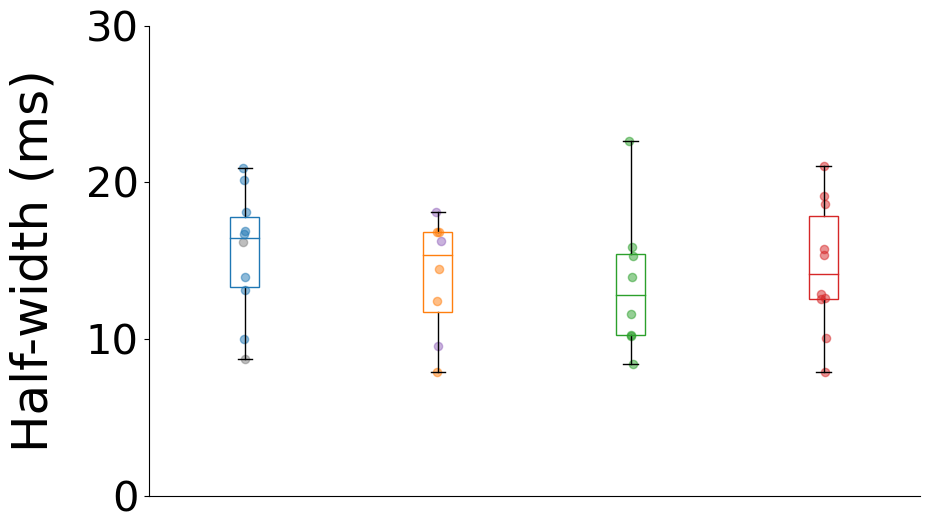

Shapiro-Wilk test for latency: Statistics=0.918, p-value=0.338, n=10
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.921, p-value=0.535, n=5
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.940, p-value=0.613, n=8
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.818, p-value=0.044, n=8
The latency data is not normally distributed (reject H0)
Caudal latency: 6.16 ± 0.21
Sample size Caudal: 10
Dorsal latency: 6.13 ± 0.31
Sample size Dorsal: 8
Rostral latency: 5.75 ± 0.39
Sample size Rostral: 8
Ventral latency: 5.91 ± 0.25
Sample size Ventral: 10
No significant difference in latency between Caudal and Dorsal: p = 0.9279
No significant difference in latency between Caudal and Rostral: p = 0.3745
No significant difference in latency between Caudal and Ventral: p = 0.4649
No significant difference in latency between Dorsal an

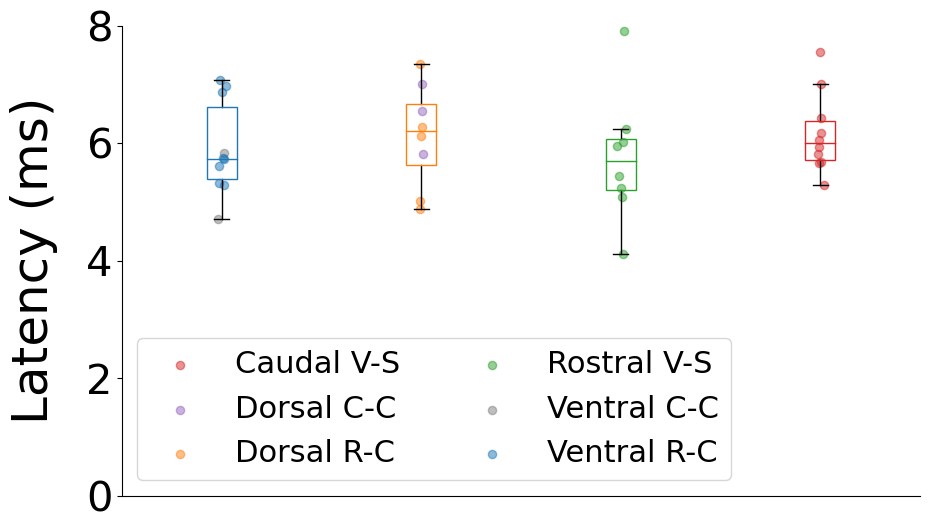

In [34]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Barrel_Type'] = all_barrel_df['Barrel_Type'].astype('category')

# font size
plt.rcParams.update({'font.size': 30})

detailed_directions = ['Ventral RAC', 'Dorsal RAC',   'Rostral VAS', 'Caudal VAS', 'Ventral CAC', 'Dorsal CAC']
det_dir_colors = {'Ventral CAC': 'tab:gray',
                  'Dorsal RAC': 'tab:orange',
                  'Ventral RAC': 'tab:blue',
                  'Dorsal CAC': 'tab:purple',
                  'Caudal VAS': 'tab:red',
                  'Rostral VAS': 'tab:green'}
barrel_types = ['Ventral', 'Dorsal', 'Rostral', 'Caudal']
box_colors = {
    'Ventral': 'tab:blue',
    'Dorsal': 'tab:orange',
    'Rostral': 'tab:green',
    'Caudal': 'tab:red',}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['halfwidth', 'latency']:
    if metric == 'latency':
        plt.figure(figsize=(10, 6))
    elif metric == 'halfwidth':
        plt.figure(figsize=(10, 6))
    handles = []
    for barrel_type in all_barrel_df['Detailed_Section'].cat.categories:
        # filter for positive values
        barrel_type_lumped = barrel_type.split(' ')[0]  # get the first part of the barrel type
        df = all_barrel_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type_lumped) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type.replace("A", '-'))
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for barrel_type in all_barrel_df['Barrel_Type'].cat.categories:

        df = all_barrel_df.copy()
        df = df[df['Barrel_Type'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{barrel_type} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {barrel_type}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][barrel_type] = df_grouped
        
    # significance testing
    next_bar = 0
    barrel_types_cats = all_barrel_df['Barrel_Type'].cat.categories
    for i1 in range(len(barrel_types_cats)):
        barrel_type1 = barrel_types_cats[i1]
        for i2 in range(i1 + 1, len(barrel_types_cats)):
            barrel_type2 = barrel_types_cats[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 0.7 + next_bar
                x_space1 = 1 + detailed_directions.index(barrel_type1)
                x_space2 = 1 + detailed_directions.index(barrel_type2)
                plt.text(x_space1 + 0.25, 6.5, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                next_bar += 1
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")

    # ANOVA comparison of all barrel types
    anova_df = all_barrel_df.copy()
    anova_df = anova_df[anova_df['Detailed_Section'].notna()]
    anova_df = anova_df[anova_df[metric] > 0]
    anova_df = anova_df.groupby(['Date', 'Slice', 'Location', 'Detailed_Section']).mean().reset_index()
    anova_df['Detailed_Section'] = anova_df['Detailed_Section'].astype('category')
    model = ols(f"{metric} ~ C(Detailed_Section)", data=anova_df).fit()
    anova_results = anova_lm(model, typ=2)
    print(f"\n\nANOVA results for {metric}:")
    print(anova_results)

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=30)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=36, labelpad=20)
    elif metric == 'latency':
        plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=36, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=30)
        plt.ylim(0, 8)
    
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xticks([])
    #plt.xlim(-0.23250000000000004, 3.2325000000000004)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'rostro_caudal_medial_lateral_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


Shapiro-Wilk test for halfwidth: Statistics=0.967, p-value=0.865, n=10
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.884, p-value=0.330, n=5
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.908, p-value=0.342, n=8
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.962, p-value=0.825, n=8
The halfwidth data is normally distributed (fail to reject H0)
Coronal halfwidth: 13.68 ± 0.99
Sample size Coronal: 18
Sagittal halfwidth: 14.85 ± 1.21
Sample size Sagittal: 13
No significant difference in halfwidth between Coronal and Sagittal: p = 0.4604
T-test results:
t-statistic: -0.7495, p-value: 0.4604


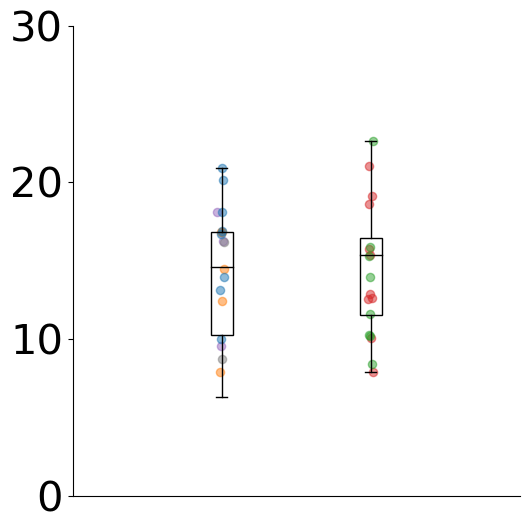

Shapiro-Wilk test for latency: Statistics=0.918, p-value=0.338, n=10
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.921, p-value=0.535, n=5
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.940, p-value=0.613, n=8
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.818, p-value=0.044, n=8
The latency data is not normally distributed (reject H0)
Coronal latency: 5.41 ± 0.37
Sample size Coronal: 18
Sagittal latency: 6.15 ± 0.24
Sample size Sagittal: 13
No significant difference in latency between Coronal and Sagittal: p = 0.1064
T-test results:
t-statistic: -1.6694, p-value: 0.1064


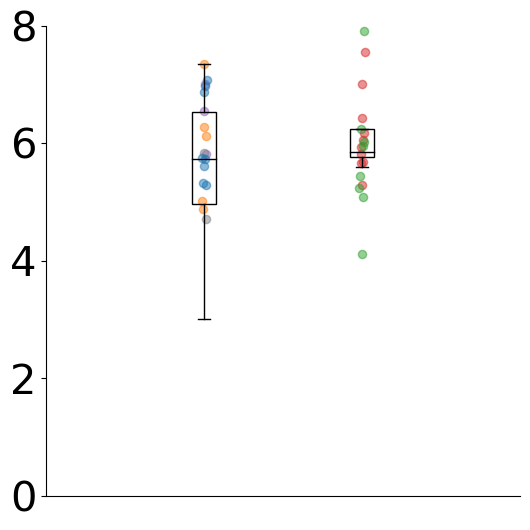

In [35]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Section'] = all_barrel_df['Section'].astype('category')

# font size
plt.rcParams.update({'font.size': 30})

sections = ['Coronal', 'Sagittal']
section_colors = {
    'Coronal': 'tab:blue',
    'Sagittal': 'red',
}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['halfwidth', 'latency']:
    plt.figure(figsize=(6, 6))

    handles = []
    for barrel_type in all_barrel_df['Detailed_Section'].cat.categories:
        # filter for positive values
        section = 'Coronal' if barrel_type.endswith("AC") else 'Sagittal'
        df = all_barrel_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for section in all_barrel_df['Section'].cat.categories:

        df = all_barrel_df.copy()
        df = df[df['Section'] == section]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{section} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {section}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][section] = df_grouped
        
    # significance testing
    next_bar = 0
    section_t = all_barrel_df['Section'].cat.categories
    for i1 in range(len(section_t)):
        barrel_type1 = section_t[i1]
        for i2 in range(i1 + 1, len(section_t)):
            barrel_type2 = section_t[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 0.7 + next_bar
                x_space1 = 1 + sections.index(barrel_type1)
                x_space2 = 1 + sections.index(barrel_type2)
                plt.text(x_space1 + 0.25, 6.5, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                next_bar += 1
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=30)
        plt.ylim(0, 30)
        #plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        #plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        #plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=30)
        plt.ylim(0, 8)
    
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xticks([])
    plt.xlim(0, 3)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'coronal_sagittal_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


Shapiro-Wilk test for instantaneous_velocity: Statistics=0.905, p-value=0.285, n=9
The instantaneous_velocity data is normally distributed (fail to reject H0)
Shapiro-Wilk test for instantaneous_velocity: Statistics=0.915, p-value=0.499, n=5
The instantaneous_velocity data is normally distributed (fail to reject H0)
Shapiro-Wilk test for instantaneous_velocity: Statistics=0.910, p-value=0.160, n=14
The instantaneous_velocity data is normally distributed (fail to reject H0)
Caudal instantaneous_velocity: 153.71 ± 15.06
Sample size Caudal: 9
Dorsal instantaneous_velocity: 124.60 ± 13.95
Sample size Dorsal: 4
Rostral instantaneous_velocity: 185.12 ± 8.76
Sample size Rostral: 3
Ventral instantaneous_velocity: 131.28 ± 6.10
Sample size Ventral: 19


ANOVA results for instantaneous_velocity:
                       sum_sq    df        F    PR(>F)
C(Barrel_Type)   19033.596397   3.0  1.06528  0.378012
Residual        184627.992383  31.0      NaN       NaN
No significant difference in instantan

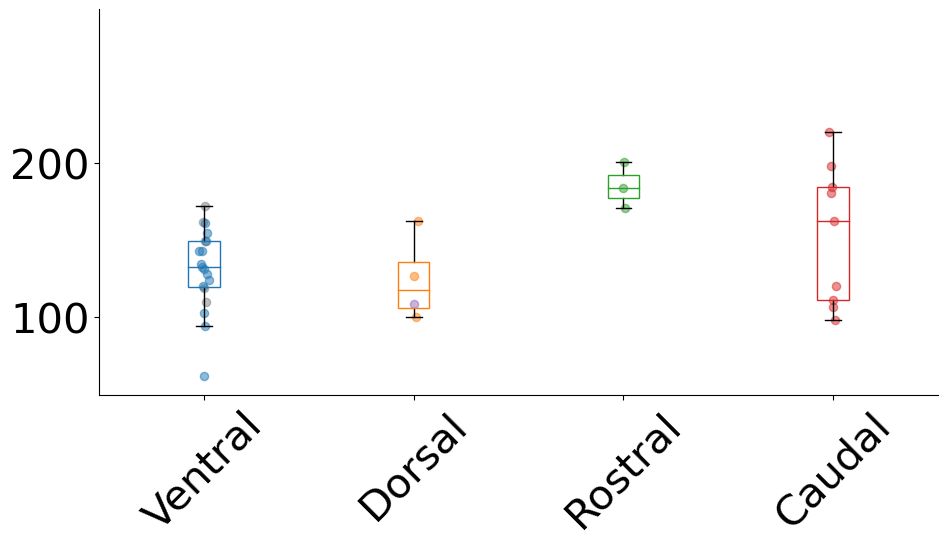

In [53]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

ladder_df['Detailed_Section'] = ladder_df['Detailed_Section'].astype('category')
ladder_df['Barrel_Type'] = ladder_df['Barrel_Type'].astype('category')

# font size
plt.rcParams.update({'font.size': 24})

detailed_directions = ['Ventral RAC', 'Dorsal RAC',   'Rostral VAS', 'Caudal VAS', 'Ventral CAC', 'Dorsal CAC']
det_dir_colors = {'Ventral CAC': 'tab:gray',
                  'Dorsal RAC': 'tab:orange',
                  'Ventral RAC': 'tab:blue',
                  'Dorsal CAC': 'tab:purple',
                  'Caudal VAS': 'tab:red',
                  'Rostral VAS': 'tab:green'}
barrel_types = ['Ventral', 'Dorsal', 'Rostral', 'Caudal']
box_colors = {
    'Ventral': 'tab:blue',
    'Dorsal': 'tab:orange',
    'Rostral': 'tab:green',
    'Caudal': 'tab:red',}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['instantaneous_velocity', ]:
    plt.figure(figsize=(10, 6))
    handles = []
    for barrel_type in ladder_df['Detailed_Section'].cat.categories:
        # filter for positive values
        barrel_type_lumped = barrel_type.split(' ')[0]  # get the first part of the barrel type
        df = ladder_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers are values > 300
            df = df[(df[metric] < 500) & (df[metric] > 50)]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type_lumped) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for barrel_type in ladder_df['Barrel_Type'].cat.categories:

        df = ladder_df.copy()
        df = df[df['Barrel_Type'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers are values < 50 and > 300
            df = df[(df[metric] < 500) & (df[metric] > 50)]

        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{barrel_type} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {barrel_type}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][barrel_type] = df_grouped

    # anova comparison of all barrel types
    anova_df = ladder_df.copy()
    anova_df = anova_df[anova_df['Barrel_Type'].notna()]
    anova_df = anova_df[anova_df[metric] > 0]
    anova_df = anova_df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
    anova_df['Barrel_Type'] = anova_df['Barrel_Type'].astype('category')
    model = ols(f"{metric} ~ C(Barrel_Type)", data=anova_df).fit()
    anova_results = anova_lm(model, typ=2)
    print(f"\n\nANOVA results for {metric}:")
    print(anova_results)


    # significance testing
    next_bar = 0
    barrel_types_cats = ladder_df['Barrel_Type'].cat.categories
    for i1 in range(len(barrel_types_cats)):
        barrel_type1 = barrel_types_cats[i1]
        for i2 in range(i1 + 1, len(barrel_types_cats)):
            barrel_type2 = barrel_types_cats[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)

            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 25 + next_bar
                x_space1 = 1 + barrel_types.index(barrel_type1)
                x_space2 = 1 + barrel_types.index(barrel_type2)
                '''plt.text((x_space1 + x_space2 ) / 2, y_space+30, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.95], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.95], color='black', linewidth=2)'''
                next_bar += 50
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=40)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=40)
        plt.ylim(0, 8)
    elif metric == 'instantaneous_velocity':
        #plt.ylabel(r'Within-Barrel Speed ($\mu$m/ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 100,  200], fontsize=30)
        plt.ylim(50, 300)
    
    plt.xticks([i for i in range(1,5)], barrel_types, fontsize=30, rotation=45)
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    #plt.xlim(-0.23250000000000004, 3.2325000000000004)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'rostro_caudal_medial_lateral_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


Coronal instantaneous_velocity: 131.54 ± 5.44
Sample size Coronal: 24
Sagittal instantaneous_velocity: 161.56 ± 12.00
Sample size Sagittal: 12
Significant difference in instantaneous_velocity between Coronal and Sagittal: p = 0.0371
T-test results:
t-statistic: -2.2788, p-value: 0.0371


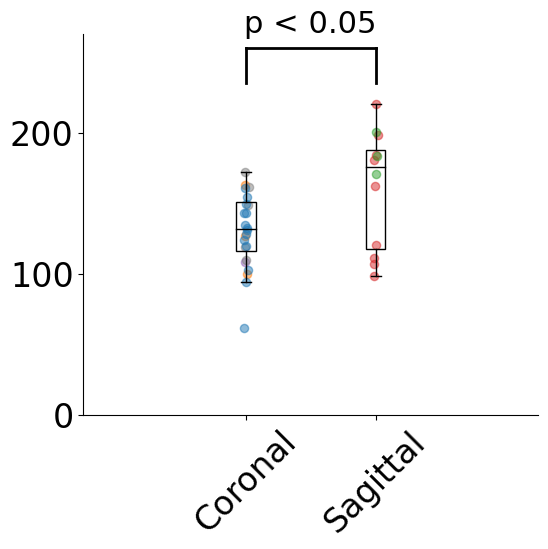

In [55]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Section'] = all_barrel_df['Section'].astype('category')

# font size
plt.rcParams.update({'font.size': 24})

sections = ['Coronal', 'Sagittal']
section_colors = {
    'Coronal': 'tab:blue',
    'Sagittal': 'red',
}


# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['instantaneous_velocity', ]:
    plt.figure(figsize=(6, 6))

    handles = []
    for barrel_type in ladder_df['Detailed_Section'].cat.categories:
        # filter for positive values
        section = 'Coronal' if barrel_type.endswith("AC") else 'Sagittal'
        df = ladder_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers are values > 300
            df = df[(df[metric] < 500) & (df[metric] > 50)]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for section in all_barrel_df['Section'].cat.categories:

        df = ladder_df.copy()
        df = df[df['Section'] == section]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers are values > 300
            df = df[(df[metric] < 500) & (df[metric] > 50)]  
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{section} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {section}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][section] = df_grouped
        
    # significance testing
    next_bar = 0
    section_t = all_barrel_df['Section'].cat.categories
    for i1 in range(len(section_t)):
        barrel_type1 = section_t[i1]
        for i2 in range(i1 + 1, len(section_t)):
            barrel_type2 = section_t[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 75 + next_bar
                x_space1 = 1 + sections.index(barrel_type1)
                x_space2 = 1 + sections.index(barrel_type2)
                plt.text((x_space1 + x_space2 ) / 2, y_space+30, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.995], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.995], color='black', linewidth=2)
                next_bar += 1
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=40)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=40)
        plt.ylim(0, 8)
    elif metric == 'instantaneous_velocity':
        #plt.ylabel(r'Within-Barrel Speed ($\mu$m/ms)', fontsize=40, labelpad=20)
        plt.yticks([0,  100,  200], fontsize=24)
        #plt.ylim(0, 200)
    
    plt.xticks([i for i in range(1,3)], sections, fontsize=24, rotation=45)
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xlim(-.25, 3.25)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'coronal_sagittal_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


In [45]:
# replace Rostral/Caudal column name with Rostral_Caudal and Medial/Lateral with Medial_Lateral
ppr_df.rename(columns={'Rostral/Caudal': 'Rostral_Caudal', 'Medial/Lateral': 'Medial_Lateral'}, inplace=True)
ppr_df.columns

Index(['ROI', 'amp', 'latency', 'halfwidth', 'X_Center', 'Y_Center', 'ROI_Set',
       'Date', 'Slice', 'Location', 'Recording', 'trace', 'trace_non_polyfit',
       'amp_array', 'Medial_Lateral', 'Section', 'Rostral_Caudal',
       'pulse1_start', 'pulse1_width', 'pulse2_start', 'pulse2_width',
       'baseline_start', 'baseline_width', 'IPI', 'is_single_pulse_control',
       'done', 'Coronal/Sagittal', 'zda_id'],
      dtype='object')

In [44]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

PatsyError: Error evaluating factor: NameError: name 'PPR' is not defined
    PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)
    ^^^

In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Rostral_Caudal'] != 'Home')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),1.206759,1.0,0.901184,0.342984
IPI,1.829139,1.0,1.365965,0.243138
IPI:C(Section),2.034233,1.0,1.519125,0.218409
Residual,590.535086,441.0,NaN,NaN


In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ C(Section)', 
                data=ppr_df[(ppr_df['IPI'] == 10)]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),7.97932,1.0,1.190514,0.280256
Residual,348.52560,52.0,NaN,NaN


In [ ]:
'''0.60 ± 0.07 at the 20 ms IPI) followed by lateral barrels (0.0012 ± 0.0008 ms⁻¹ and 0.73± 0.05), and 
rostral barrels (0.0011 ± 0.0009 ms⁻¹, 0.78 ± 0.07). However, only the caudal recovery is significantly different,
 with a slower rate than lateral (T = 3.5, p = 0.003) and or medial (T = 5.4, p < 0.001). In particular, caudal barrels do not show recovery 
within this range of time intervals (slope = -0.00004± 0.00008 ms⁻¹) and show the least depression
 among all the directions with a PPR at 20 ms of 0.83 ± 0.07 '''

## 